## Take thermal lensing data

What this code does:

1.) Turns on the HWS to allow it to warm up and reach thermal equilibrium.

2.) Takes reference images, averages them and finds centroids. Laser needs to be on. 

3.) Sends an email to inform you that the reference centroids have been saved. This means that you will need to turn on the heater.

4.) Takes the live images, averages and saves the centroids found from them.

5.) calculate the gradients and thus the wavefront deformation. 

User is responsible for:
- inputing folder name to save to
- choosing a reasonable exposure
- specifying the correct camera parameters (pixel size, image size, etc.)
- providing correct magnification
- turning on laser and heater
- check for and remove any faulty pixels of HWS camera (code has function for this)

Imports

In [1]:
#Import ximea (camera software)
import sys
sys.path.append('C:/XIMEA/API/Python/v3')

import ximea
print('ximea version ', ximea.__version__)
from ximea import xiapi

#import useful things
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import keyboard

# Import HS classes assuming they reside one directory above
hspath = os.path.abspath('..')
if hspath not in sys.path:
    sys.path.append(hspath)

# use the location where you have saved the HWS modules on your own computer
sys.path.append('C:/Users/katel/Documents/honours_project')

from HS_Image import *
from HWS.HS_Centroids import *
from HWS.HS_Gradients import *
from HWS.HS_WFP import *
import HWS.HSM_WFN as HSM_WFN

import time
import scipy.optimize as opt

# for sending notification email
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

ximea version  4.28.00


User Options (make sure these are applicable)

In [26]:
# number of frames to take and average
N = 100
# time to warm up before taking data
T = 7200 #  2 hours in seconds
# name of folder to save average images in
folder_name = 'center_heater_19_09'
# translation of translation stage
translation = 0 # mm

# do you want the code to send you an email to let you know when the centroids have been saved?
send_email = False
# email adress to send notification to (use a GMail adress)
email_adress = "katelyn.jardine03@gmail.com"
# this must be an 'app password', which allows other apps to sign into your GMail account
my_password = r"woejudnnunbeqlym"

# size of image taken by HWS (pixels)
img_size = 2048
# distance from CCD array to Heartmann plate
lever_arm = 8.73e-3 # (m)
# magnification due to imaging telescope
magnification = 1/0.509
# pixel size in CCD array
pixel_size = 5.5e-6
# wavelength of SLD light (m)
wavelength = 830e-9
# distance between holes on the Heartmann plate
hole_spacing = 4e-4 # (m)
# origin
origin = 2047/2

# camera exposure for HWS (us)
exposure = 1505

# location of this file, where images save to
file_path = os.getcwd()

In [27]:
# # open the camera
# cam = xiapi.Camera()
# cam.open_device()

# # set camera exposure
# cam.set_exposure(exposure)

Functions

In [28]:
def take_and_average_frames(cam, N):
    """_function to take and average images from HWS_

    Args:
        cam (_camera_): _xiapi.camera_
        N (_int_): _number_of_frames_

    Returns:
        _np.array_: _average_image_
    """
    
    img = xiapi.Image()
    temp = np.zeros((img_size, img_size))
    for i in range(N):
        cam.get_image(img)
        temp += img.get_image_data_numpy()

    return (temp / N)



def remove_that_one_feral_pixel(image, problem_x = 493, problem_y = 1745):
    '''Remove a faulty pixel in the CCD array of the HWS by replacing it with the average of those around it

    Args:
        image (_np array_): image 
        problem_x (_int_): x coordinate of problem pixel
        problem_y (_int_): y coordinate of problem pixel
    
    Returns:
        np.array: image with the problem pixel removed
    '''

    image[problem_x, problem_y] = (image[problem_x + 1, problem_y] + image[problem_x - 1, problem_y] +
                                    image[problem_x, problem_y + 1] + image[problem_x, problem_y - 1])/4
    return image



def find_cent_position_ref(cam, n, background):
    '''find the centroids which will be used as a reference to find all other centroids
    
    Args:
        cam (_camera_): _xiapi.camera_
        N (_int_): _number_of_frames_
        background(_np.array_): background image

    Returns:
        np.array: reference centroids
    '''

    #start data acquisition
    cam.start_acquisition()
    #take and average images
    reference_image_raw = take_and_average_frames(cam, n)
    # remove faulty pixel from the image
    reference_image = remove_that_one_feral_pixel(reference_image_raw)
    #stop data acquisition
    cam.stop_acquisition()
    # find reference centroids
    hsi_ref = HS_Image()
    hsi_ref.background = background
    hsi_ref.original_image = reference_image
    hsi_ref.original_image.shape = (2048, 2048)
    hsi_ref.process_image()
    hsc_ref = HS_Centroids()
    hsc_ref.hsimage = hsi_ref
    hsc_ref.find_centroids_from_image(to_filter_spots = True, size_threshold = 50)
    ref_centroids = hsc_ref.centroids
    return ref_centroids



def record_temperature_of_camera(T):
    '''turn on a ximea camera and take but do not save images. Record the temperature of the camera each second
    
    Args:
        T (_int_): time in seconds to warm up the camera for

    Returns:
        _np.array_: time or each measurment, temperature at each time
    '''

    img = xiapi.Image()
    time_list = np.zeros(T)
    temperature_list = np.zeros(T)
    cam.start_acquisition()
    for i in range(T):
        time.sleep(1)
        cam.get_image(img)
        time_list[i] = time.time()
        temperature_list[i] = cam.get_temp()
    cam.stop_acquisition()
    return time_list, temperature_list



def plot_gradients_and_wf(what_grad, wavefront, title):
     '''plot gradients and wavefunctions
     
     Args:
          what_grad (hsg) = gradients to plot
          wavefront (wf) = wavefront deformation to plot
          title (string) = title of plot
        '''

     gspacing = 4 * what_grad.pixel_size

     limits = {}
     limits["x"] = np.array(
          [what_grad.gradients[:,2].min() - gspacing, what_grad.gradients[:,2].max() + gspacing]
     )

     limits["y"] = np.array(
          [what_grad.gradients[:,3].min() - gspacing, what_grad.gradients[:,3].max() + gspacing]
     )

     xaxis = np.arange(limits["x"][0], limits["x"][1], gspacing) * 1e3
     yaxis = np.arange(limits["y"][0], limits["y"][1], gspacing) * 1e3 


     plt.figure(title, figsize=(9.6, 3.8))
     centroids = what_grad.gradients[:,2:]

     gs=gridspec.GridSpec(1,3, width_ratios=[4,4,0.2])
     axn_g = plt.subplot(gs[0])
     axn_w = plt.subplot(gs[1])
     axn_c = plt.subplot(gs[2])

     axn_g.quiver(what_grad.gradients[:,2], what_grad.gradients[:,3], what_grad.gradients[:,0], what_grad.gradients[:,1])
     #axn_g.quiver(centroids[:,0], centroids[:,1], hsg_res.gradients[:,0],hsg_res.gradients[:,1])
     axn_g.set_aspect('equal')
     axn_g.set_title('Gradients')
     axn_g.set_xlim([limits["x"][0], limits["x"][1]])
     axn_g.set_ylim([limits["y"][0], limits["y"][1]])

     p_wfn = axn_w.contourf(xaxis, yaxis, wavefront, origin='lower', cmap = plt.cm.magma, levels = 30)
     # axn_w.set_xlim([limits["x"][0], limits["x"][1]])
     # axn_w.set_ylim([limits["y"][0], limits["y"][1]])
     
     axn_w.set_title('Wavefront')

     plt.colorbar(p_wfn, cax=axn_c)
     plt.savefig('gradients_and_wavefront')
     plt.draw()



def remove_nasty_gradients(gradients, factor):
    '''find and remove gradinets which are outliers (exessively large)
    
    Args:
        gradients (_np.array_): gradients, as found from centroids

    Returns: _np.array_: gradients, with outliers removed
    '''

    bad_no = []
    average_gradient = np.mean(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    print('ave', average_gradient)
    sd_gradient = np.std(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    print('sd', sd_gradient)
    limit = average_gradient + (sd_gradient * factor)
    
    for i,_ in enumerate(gradients[:, 0]):

        if np.sqrt(((gradients[i,0])**2) + (gradients[i,1])**2) > limit:
            bad_no.append(i)    
            gradients[i,0] = 0
            gradients[i,1] = 0
    # return np.delete(gradients, bad_no, axis = 0)
    return gradients

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, offset):
    ''' equation of a 2D gaussian function'''
    x, y = xy
    result = amplitude * np.exp(-1*(((x - xo)**2/(2*sigma_x**2)) + ((y - yo)**2/(2*sigma_y**2)))) + offset
    return result.ravel()

def apply_gauss_fit(fit_to, xy, p0):
    popt, pcov = opt.curve_fit(twoD_Gaussian, xy, fit_to, p0, maxfev = 5000)
    return popt, pcov

Background

In [29]:
# Check if a background image has been taken and saved previously
# if it is nececary to take background frames, ensure that the laser is turned off
if os.path.exists(os.path.join(file_path, f'background.npy')):
    print('background already taken')
else:
    time.sleep(60)
    # one minute allowed to turn off lights
    cam.start_acquisition()

    #take and average images
    background = take_and_average_frames(cam, 100)
    average_background = np.mean(background)
    background[493, 1745] = average_background # get that nonsense pixel gone
    background.shape = (img_size, img_size)

    cam.stop_acquisition()
    #save background image, not in folder to save centroids
    np.save(os.path.join(file_path, f'background'), background)

background already taken


Reference centroids

In [ ]:
# allow camera to warm up
time_list, temperature_list = record_temperature_of_camera(T)
time_temp_table = np.array([time_list, temperature_list])

# check to see if a folder to save to has already been created, and if not make one
if os.path.exists(os.path.join(file_path, folder_name)):
    print(f'{folder_name}, folder already exists')
else:
    os.makedirs(os.path.join(file_path, folder_name))

# save time, temperature data
np.save(os.path.join(file_path, os.path.join(folder_name, 'camera_temperature_warm_up')), time_temp_table)
print('warm-up complete')

# load background image
background = np.load(os.path.join(file_path, f'background.npy'))

#find reference centroids
ref_centroids = find_cent_position_ref(cam, N, background)

# save reference centroids
np.save(os.path.join(file_path, os.path.join(folder_name, f'reference_centroids')), ref_centroids)
print('reference centroids saved')

# can allow the code to send you an email when the reference centroids have been saved
if send_email == True:
    # send email to let the user know that the reference centroids have been saved
    msg = MIMEMultipart('alternative')
    msg['Subject'] = "HWS Update"
    msg['From'] = email_adress
    msg['To'] = email_adress

    html = '<html><body><p> Reference centroids have been saved. </p></body></html>'
    part2 = MIMEText(html, 'html')

    msg.attach(part2)

    # Send the message via gmail's regular server, over SSL
    s = smtplib.SMTP_SSL('smtp.gmail.com')
    # uncomment if interested in the actual smtp conversation
    # s.set_debuglevel(1)
    # do the smtp auth; sends ehlo if it hasn't been sent already
    s.login(email_adress, my_password)

    # send email
    s.sendmail(email_adress, email_adress, msg.as_string())
    s.quit()
    print('email sent successfully ')

# keep camera on and taking images so it doesn't need to warm up again for live images.
# press 'e' to stop idling and save the temperature data.
print('camera staying warm...')
time_list_idle, temperature_list_idle = np.array(([], []))
while True:
    # Add to the idle data arrays until the user clicks the 'e' on the keyboard
    time_list_idle_new, temperature_list_idle_new = record_temperature_of_camera(1)
    time_list_idle = np.append(time_list_idle, time_list_idle_new)
    temperature_list_idle = np.append(temperature_list_idle, temperature_list_idle_new)

    if keyboard.is_pressed("e"):
        print('camea idle stopped')
        break 

# save time, temperature data 
time_temp_table_idle = np.array([time_list_idle, temperature_list_idle])
np.save(os.path.join(file_path, os.path.join(folder_name, 'camera_temperature_idle')), time_temp_table_idle)

Live centroids

In [ ]:
# allow optic to warm up
cam.stop_acquisition()
time_list, temperature_list = record_temperature_of_camera(T)
print('warm-up complete')

#take and average live images
cam.start_acquisition()
live_image_raw = take_and_average_frames(cam,N)
cam.stop_acquisition()

# get rid of that %#$@ pixel
live_image = remove_that_one_feral_pixel(live_image_raw)

# find live centroids
hsi_live = HS_Image()
hsi_live.background = background
hsi_live.original_image = live_image
hsi_live.original_image.shape = (img_size, img_size)
hsi_live.process_image()
hsc_live = HS_Centroids()
hsc_live.hsimage = hsi_live

# load reference centroids and use to find live cents
ref_cents_loaded = np.load(os.path.join(file_path, os.path.join(folder_name, f'reference_centroids.npy')))
hsc_live.find_centroids_using_template(refcents = ref_cents_loaded)
live_centroids = hsc_live.centroids

# save live centroids
np.save(os.path.join(file_path, os.path.join(folder_name, f'live_centroids')), live_centroids)
print('live centroids saved')

cam.close_device()

if send_email == True:
    # send email to let the user know that the reference centroids have been saved
    msg = MIMEMultipart('alternative')
    msg['Subject'] = "HWS Update"
    msg['From'] = email_adress
    msg['To'] = email_adress

    html = '<html><body><p> Live centroids have been saved. </p></body></html>'
    part2 = MIMEText(html, 'html')

    msg.attach(part2)

    # Send the message via gmail's regular server, over SSL
    s = smtplib.SMTP_SSL('smtp.gmail.com')

    s.login(email_adress, my_password)

    # send email
    s.sendmail(email_adress, email_adress, msg.as_string())
    s.quit()
    print('email sent successfully ')


Centroiding, RMS and Wavefront Aberrations

Plot reference centroids

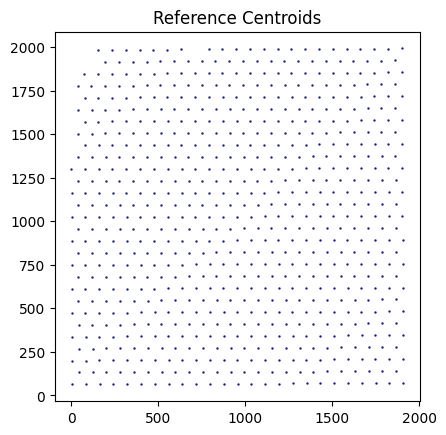

In [32]:
# load reference centroids
ref_cents_loaded = np.load(os.path.join(file_path, os.path.join(folder_name, f'reference_centroids.npy')))

# plot reference centroids
fig_ref = plt.figure('Reference Centroids')
plt.title('Reference Centroids')
plt.scatter(ref_cents_loaded[:,0], ref_cents_loaded[:,1], color = 'midnightblue', s = 0.5)
plt.gca().set_aspect('equal')
plt.show()

plot live centroids

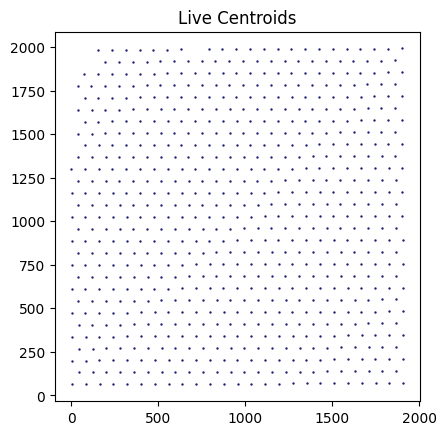

In [33]:
live_cents_loaded = np.load(os.path.join(file_path, os.path.join(folder_name, f'live_centroids.npy')))

# plot the live centeroids
fig_live = plt.figure('Live Centroids')
plt.title('Live Centroids')
plt.scatter(live_cents_loaded[:,0], live_cents_loaded[:,1], color = 'midnightblue', s = 0.5)
plt.gca().set_aspect('equal')
plt.show()

Find and plot gradients

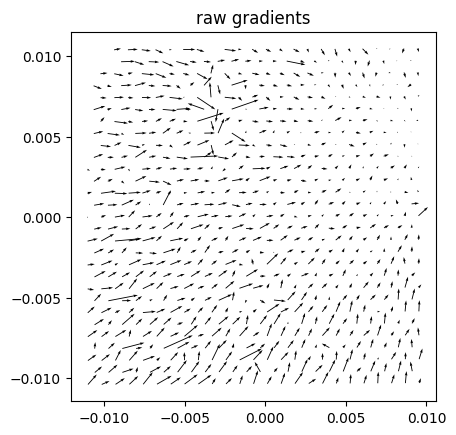

In [34]:
hsc_ref = HS_Centroids()
hsc_live = HS_Centroids()
hsc_ref.centroids = ref_cents_loaded
hsc_live.centroids = live_cents_loaded

hsg = HS_Gradients(hsc_ref, hsc_live)
hsg.origin = array([origin, origin])
hsg.pixel_size = pixel_size
hsg.magnification = magnification
hsg.construct_gradients()
raw_gradients = hsg.gradients

# plot gradients
plt.title('raw gradients')
plt.gca().set_aspect('equal')
plt.quiver(raw_gradients[:,2], raw_gradients[:,3], raw_gradients[:,0], raw_gradients[:,1])
plt.show()

Remove nasty gradients

ave 2.977300581392744e-06
sd 2.1508353326552296e-06


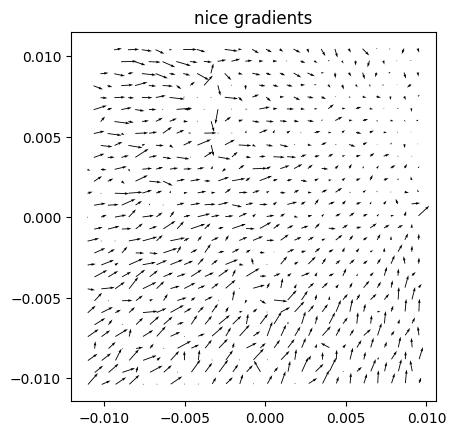

In [35]:
# nice gradients
nice_grads = remove_nasty_gradients(raw_gradients, factor = 2)
hsg_ng = HS_Gradients()
hsg.origin = array([origin, origin])
hsg.pixel_size = pixel_size
hsg.magnification = magnification
hsg_ng.gradients = nice_grads
hsg_ng.final_centroids = nice_grads[:,2:]

# plot gradients
plt.title('nice gradients')
plt.gca().set_aspect('equal')
plt.quiver(nice_grads[:,2], nice_grads[:,3], nice_grads[:,0], nice_grads[:,1])
plt.show()

Remove prism

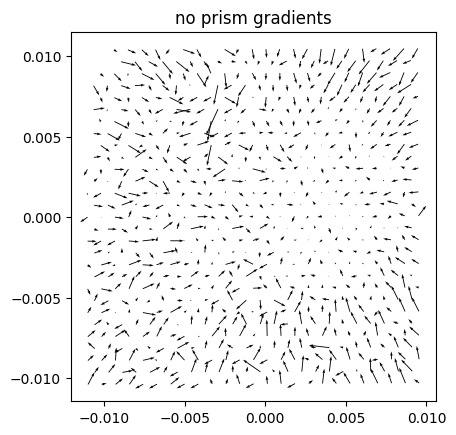

In [36]:
# numerical method of removing prism
prism_x = np.mean(hsg_ng.gradients[:, 0])
prism_y = np.mean(hsg_ng.gradients[:, 1])

hsg_noprism = hsg_ng

hsg_noprism.gradients[:, 0] = hsg_ng.gradients[:, 0] - prism_x
hsg_noprism.gradients[:, 1] = hsg_ng.gradients[:, 1] - prism_y

no_prism_grads = hsg_noprism.gradients

np.save(os.path.join(file_path, os.path.join(folder_name, f'gradients')), no_prism_grads)

plt.title('no prism gradients')
plt.gca().set_aspect('equal')
plt.quiver(no_prism_grads[:,2], no_prism_grads[:,3], no_prism_grads[:,0], no_prism_grads[:,1],)
plt.show()


Calculate the wavefront

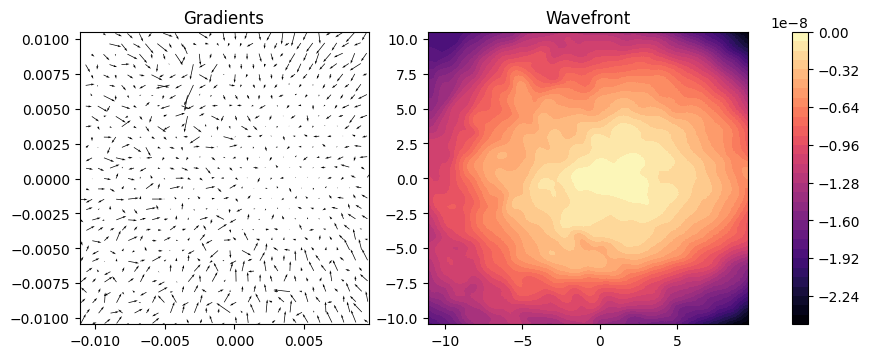

In [37]:
# calculate wavefront
wf_noprism_inv = HSM_WFN.calculate_wf_from_hsgradients(hsg_noprism, to_interpolate = False)
wf_noprism = -wf_noprism_inv

np.save(os.path.join(file_path, os.path.join(folder_name, f'wfn')), wf_noprism)
plot_gradients_and_wf(hsg_noprism, wf_noprism, 'Numerical without Prism')

gaussian fit

1.7845605110701774e-07 -0.20214456591963376 0.0254376858267673 32.14409276737365 26.99629206225469 -1.7879689314538894e-07


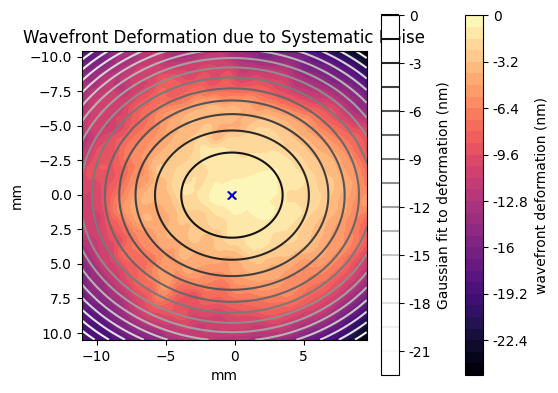

In [ ]:
# format axes
gspacing = 4 * hsg_noprism.pixel_size

limits = {}
limits["x"] = np.array(
     [hsg_noprism.gradients[:,2].min() - gspacing, hsg_noprism.gradients[:,2].max() + gspacing]
)

limits["y"] = np.array(
    [hsg_noprism.gradients[:,3].min() - gspacing, hsg_noprism.gradients[:,3].max() + gspacing]
)

xaxis = np.arange(limits["x"][0], limits["x"][1], gspacing) *1e3
yaxis = np.arange(limits["y"][0], limits["y"][1], gspacing) *1e3


# Gaussian fit to the data
xm, ym = np.meshgrid(xaxis, yaxis)
xmym = (xm, ym)
p0 = np.array((1e-8, 0, 0, 25, 25, -1e-8))

popt, pcov = apply_gauss_fit(np.ravel(wf_noprism), xmym, p0)
print(*popt)
data_fitted = np.reshape(twoD_Gaussian((xm, ym), *popt), (np.shape(wf_noprism)[0], np.shape(wf_noprism)[1]))

plt.subplots(1, 1, figsize = (5.5, 4), layout = 'constrained')
plt.subplot(1, 1, 1)
plt.contourf(xaxis, yaxis, wf_noprism, cmap = 'magma', levels = 30)
plt.xlabel('mm')
plt.ylabel('mm')

# format colourbar
func = lambda x,pos: "{:g}".format(x*1e9)
fmt = matplotlib.ticker.FuncFormatter(func)
cbar1 = plt.colorbar(format=fmt)
cbar1.set_label('wavefront deformation (nm)')

plt.contour(xaxis, yaxis, data_fitted, cmap = 'Greys', levels = 15)
cbar2 = plt.colorbar(format=fmt)
cbar2.set_label('Gaussian fit to deformation (nm)')
plt.gca().invert_yaxis()
plt.title('Thermal Deformation, Center Heater')
plt.savefig(f'wavefront_translation_{translation}')
plt.gca().set_aspect('equal')

# centre of gaussian fit
plt.plot(popt[1], popt[2], 'x', color = 'black')
plt.plot(xaxis[225], yaxis[218], 'x', color = 'blue')

plt.title('Wavefront Deformation')
plt.show()

Plot temperature of camera during warm up and idle

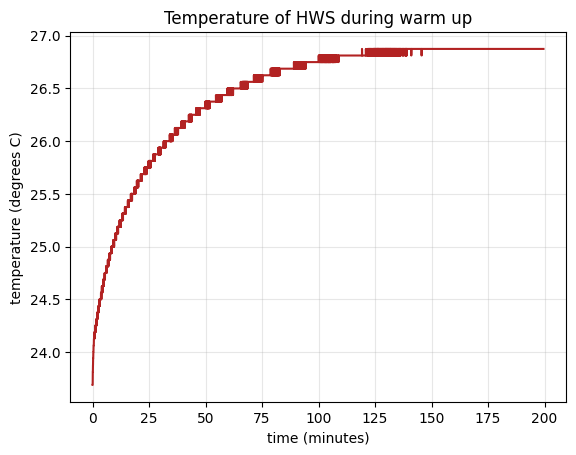

In [ ]:
# It can be helpful to know weather the camera has reached a stable temperature. If it has not, this adds uncertainty to the measurments.

# load data to plot
warm_up = np.load(os.path.join(file_path, os.path.join(folder_name, 'camera_temperature_warm_up.npy'))) 

# warm up
initial_time_1 = warm_up[0, 0] # time when data recording commenced
seconds_1 = warm_up[0, :] - initial_time_1 # rescale x axis so time zero is when data recording began
degrees_1 = warm_up[1, :] # the temperature

plt.plot(seconds_1/60, degrees_1, color = 'firebrick')
plt.title('Temperature of HWS during warm up')
plt.xlabel('time (minutes)')
plt.ylabel('temperature (degrees C)')
plt.grid(alpha = 0.3)

plt.show()